In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
%matplotlib inline

In [112]:
import numpy as np
from scipy.stats import pareto

class CMC:
    
    def __init__(self, shape = None, scale = None, c = 100, N = 10, n = 100, K = 50):
        
        if shape is None:
            self.shape = np.linspace( 1, 2, N, endpoint=False)
        else:
            self.shape = shape
            
        if scale is None:
            self.scale = np.repeat(1, len(shape))
        else:
            self.scale = scale
        
        assert isinstance(n, int), "n must be an integer."
        
        self.c = c
        self.N = len(self.shape)
        self.n = n
        self.K = K
        
        
        
        
    def take_sample(self):
        
        self.sample = np.asmatrix([np.random.pareto(self.shape[i], self.n)*self.scale[i] 
                                   for i in range(len(self.shape))])
        
        #self.tabulateDist = np.asmatrix([preto.sf(range(1, np.max()), self.shape[i])*self.scale[i] 
                          #         for i in range(len(self.shape))])
        
    def cmc(self):
    
        def compZi(i, sample, c, shapei, scalei):
            
            sampleIX = sample[range(i) + range(i+1, sample.shape[0]), :]
            #return(pareto.sf(np.max(np.concatenate((c - np.sum(sampleIX, 0), 
             #                                       np.max(sampleIX, 0))), 0), shapei, scale = scalei))
            return(np.max(np.concatenate((c - np.sum(sampleIX, 0), 
                                                    np.max(sampleIX, 0))), 0))
        
        
        self.Zbar = np.mean(np.concatenate([compZi(i, self.sample, self.c, self.shape[i], self.scale[i]) 
                         for i in range(1)]), 0)
        #self.Zbar = np.mean(self.Z)
        
    def mc(self):
        
        
        self.muHat = np.zeros(self.sample.shape[0])
        
        for i in range(self.sample.shape[0]):
            #s = 0
            #for j in range(self.sample.shape[1]):
                
            #    s += self.sample[i,j]
                
            self.muHat[i] = (np.sum(self.sample[i,:]) > self.c).astype(int)
        
        s = 0
        for i in self.muHat:
            
            s += i
            
        #self.muBar = np.float(s)/len(self.muHat)
        #self.muHat = (np.sum(self.sample, 0) > self.c).astype(int)
        self.muBar = np.mean(self.muHat)
        
    def compRelEff(self, mu, kappa = 0.01):
        
        def mccmc(obj):
            obj.take_sample()
            obj.cmc()
            obj.mc()
            
            return((obj.muBar, obj.Zbar))
        
        self.muHatZbars = np.asmatrix([mccmc(self) for i in range(self.K)])
        
        self.relEff = np.log(np.mean(np.abs(self.muHatZbars[:,1] - mu) > 
                              kappa * mu)) - np.log(np.mean(np.abs(self.muHatZbars[:,0] - mu) > 
                                                         kappa * mu))
        


In [113]:
def timeIt(shape = np.linspace( 1, 2, 10, endpoint=False), 
                    n = np.linspace(2, 20000, 1000).astype(np.int), kappa = .01, k = 5, c = 100, verbose = False):
    
    print(shape)
    
    times = np.zeros((k, len(n), 2))
    for i in range(len(n)):
        
        tmp = CMC(shape = shape, n = n[i], c = c)
        
        for j in range(k):
            
            tmp.take_sample()
            s = time.time()
            tmp.mc()
            e1 = time.time()
            tmp.cmc()
            e2 = time.time()
            times[j, i, :] = [e1-s, e2-e1]
    
    return(n, times)

In [130]:
times160 = timeIt(n = np.linspace(5000,400000,150, endpoint=True).astype(np.int))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]


In [143]:
n = np.linspace(5000,400000,150, endpoint=True)
times_df = pd.DataFrame(times160[1].reshape([len(n)*5, 2]))
times_df.columns = ["MC", "CMC"]
times_df["n"] = np.tile(times160[0], 5)

In [144]:
times_melt = times_df.melt(id_vars="n", value_vars=["MC", "CMC"])

In [161]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(times160[0],
                       np.log10(np.mean(times160[1], 0)[:,1]) - np.log10(np.mean(times160[1], 0)[:,0]))
xs = np.linspace(times160[0][0], times160[0][-1], 1000)

In [165]:
times_df = times_df.assign(logRatio = np.log10(times_df["CMC"]) - np.log10(times_df["MC"]))
md = smf.ols("logRatio ~ n",times_df.loc[times_df.loc[:,"n"] > 250000,:])
mdf = md.fit()
times_df = times_df.assign(fitted = mdf.params[0] + mdf.params[1] * times_df["n"])
mdf.params[1]
mdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logRatio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2913
Date:                Wed, 08 May 2019   Prob (F-statistic):              0.590
Time:                        10:14:49   Log-Likelihood:                 224.59
No. Observations:                 285   AIC:                            -445.2
Df Residuals:                     283   BIC:                            -437.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9257      0.049     18.780      0.000       0.829       1.023
n           8.094e-08    1.5e-07      0.540      0.590   -2.14e-07    3.76e-07
==============================================================================
Omnibus:                       39.105   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.450
Skew:                          -1.050   Prob(JB):                     4.08e-12
Kurtosis:                       3.101   Cond. No.                     2.48e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

(5000, 400000)

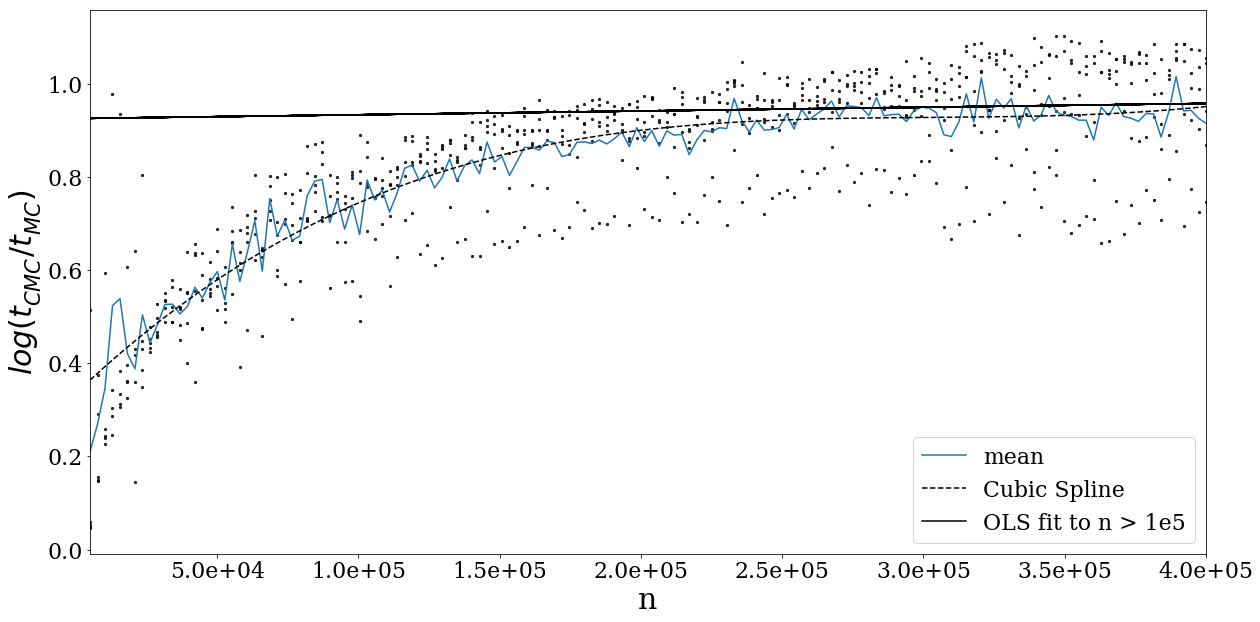

In [172]:
f, ax = plt.subplots(figsize = [20, 10])
ax.scatter(times_df["n"], y = np.log10(times_df["CMC"]) - np.log10(times_df["MC"]), c = "k", alpha = .8, s = 5)
ax.plot(times160[0],np.log10(np.mean(times160[1], 0)[:,1]) - np.log10(np.mean(times160[1], 0)[:,0]),
        alpha = 1, label = "mean")
ax.plot(xs, spl(xs),c = "k", ls = "dashed", label = "Cubic Spline")
ax.plot(times_df["n"], times_df["fitted"], c = "k", label = "OLS fit to n > 1e5")
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$ log(t_{CMC}/t_{MC})$", fontsize = 30)
ax.legend(loc = 4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1e'))
ax.set_xlim([5000, 400000])

In [69]:
pareto.sf([1,2,3], 1)

array([1.        , 0.5       , 0.33333333])

In [73]:
shape = [1,2,3]
sample = np.asmatrix([np.random.pareto(shape[i], 10)
                                   for i in range(len(shape))])

matrix([[  7.1,   4.5,   4.3, 222.5,   2.6,   0.6,   3.8,  16.4,  15.8,
          83.2],
        [  1. ,   3.1,   7.2,   3.9,   7.8,   0.4,   0.5,   4.1,   1.2,
           1.1],
        [  3.6,   2.3,   4.7,   1.1,   3.4,   7.6,   2. ,   0.4,  17.4,
           3.9]])